# Step 0: Imports

Question: 

- Do the attention heads learn to attend to the same positional encodings
- do interp -- what is it doing? can we figure out?
- update: I think we should do interp once it's bigger. 

In [1]:
# using tqdm.auto glitches out collaborative editing
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from math import sqrt
from collections import deque
import os
import random
from concurrent.futures import ProcessPoolExecutor
import pickle

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda", "CUDA is not available. Please check your GPU setup."

In [2]:
# VTXS numbers here are inclusive
MIN_VTXS = 3
MAX_VTXS = 15
MAX_TUNE_VTXS = 7 # 15
AVG_DEG = 2
SEQ_LEN = MAX_VTXS + 1 # means 32 edges, final token is the target vertex
PAD_TOKEN = 0
# vertices are labelled 1,2,...,63
# we also have a padding token which is 0.

# Step 1: Generate synthetic data

In [18]:
# original task data
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0 2]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)
# the final 2 means which vertex we're going to 

# the label is the shortest distance from vtx 1 to vtx 2
# or "number of vertices" if no path exists

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = [random.randint(1, n) for _ in range(AVG_DEG * n)]
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            edge_list += [min(u,v),max(u,v)]
            adjacencies[u].add(v)
            adjacencies[v].add(u)
    edge_list += [PAD_TOKEN]*(2*SEQ_LEN-1-len(edge_list))
    return edge_list, adjacencies

"""
input: G, represented as an adjacency list
output: [number of vertices]+[d(1,i) for i in range(n)] if target=None
if target is set to some value, then we instead just output that specific distance
"""
def SSSP(G, target=2):
    dist = [MAX_VTXS for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == MAX_VTXS:
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    return dist[target]
    if target is not None:
        return dist[target]
    else:
        return dist

def mkbatch(size):
    graphs1 = []
    distance1 = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS)
        edge_list, adj_list = random_graph(n)
        dist = SSSP(adj_list)
        edge_list[-1] = 2 # target token
        graphs1.append(edge_list)
        distance1.append(dist)
    
    data = torch.tensor(graphs1)
    labels = torch.tensor(distance1, dtype=torch.bfloat16)
    padding = data == PAD_TOKEN
    return data, labels, padding

def savebatch(size, idx):
    data, labels, padding = mkbatch(size)
    everything = {
        "data": data,
        "labels": labels,
        "padding": padding,
    }
    
    with open(f'data/{idx}.pickle', 'wb') as file:
        pickle.dump(everything, file)

def vertices_on_shortest_12_path(G, target=2):
    dist = [MAX_VTXS for _ in G]
    parent = [-1 for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == MAX_VTXS:
                parent[x] = vtx
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    path = [x]
                    while parent[x] != -1:
                        x = parent[x]
                        path.append(x)
                    return list(reversed(path))
    return []

def mktunebatch(size, test=False):
    graphs = []
    distance = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS if test else MAX_TUNE_VTXS)
        while True:
            edge_list, adj_list = random_graph(n)
            path = vertices_on_shortest_12_path(adj_list)
            if len(path) > 1:
                target_vtx_idx = random.randrange(1, len(path))
                target_vtx = path[target_vtx_idx]
                edge_list[-1] = target_vtx
                graphs.append(edge_list)
                distance.append(target_vtx_idx)
                break
    
    data = torch.tensor(graphs, device=device)
    labels = torch.tensor(distance, dtype=torch.bfloat16, device=device)
    padding = data == PAD_TOKEN
    return data, labels, padding

In [4]:
# Only need to run this once to generate training data
# RESTART THE KERNEL BEFORE RUNNING AND ONLY RUN THE CELLS ABOVE
# Python is slow and awful

# with ProcessPoolExecutor() as executor:
#     for i in range(1000):
#         executor.submit(savebatch, 2**20, i)
#     executor.shutdown()

In [5]:
mkbatch(5)

(tensor([[ 1,  2,  5, 12,  3, 12,  2, 11,  9, 12,  2, 10,  1,  7,  1,  2,  9, 10,
           1,  9,  4, 12,  0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 9, 12,  4,  7,  8, 10,  5, 13,  1, 13,  3, 13,  7, 12,  5,  6,  3,  4,
           6, 13,  2,  7,  0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 1,  5,  8, 12,  2,  9,  2,  7,  5,  9, 10, 11,  6, 10,  4, 12,  1,  2,
           4, 11,  2,  5,  2,  4,  0,  0,  0,  0,  0,  0,  2],
         [ 5,  8,  3,  6,  4,  5,  2,  3,  4,  9,  3,  8,  5,  7,  4,  9,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 6, 13,  1, 13,  1,  4,  6, 13,  5,  7,  2,  4, 10, 12,  4,  6,  8, 11,
           7, 11,  3,  8,  3,  5,  4, 12,  0,  0,  0,  0,  2]]),
 tensor([ 1.,  5.,  1., 15.,  2.], dtype=torch.bfloat16),
 tensor([[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False,  True,  True,  True,  True,  Tr

(array([523.,   0.,   0.,   0., 390.,   0.,   0.,   0.,   0., 238.,   0.,
          0.,   0.,  92.,   0.,   0.,   0.,   0.,  40.,   0.,   0.,   0.,
         15.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 743.]),
 array([ 1.     ,  1.21875,  1.4375 ,  1.65625,  1.875  ,  2.09375,
         2.3125 ,  2.53125,  2.75   ,  2.96875,  3.1875 ,  3.40625,
         3.625  ,  3.84375,  4.0625 ,  4.28125,  4.5    ,  4.71875,
         4.9375 ,  5.15625,  5.375  ,  5.59375,  5.8125 ,  6.03125,
         6.25   ,  6.46875,  6.6875 ,  6.90625,  7.125  ,  7.34375,
         7.5625 ,  7.78125,  8.     ,  8.21875,  8.4375 ,  8.65625,
         8.875  ,  9.09375,  9.3125 ,  9.53125,  9.75   ,  9.96875,
        10.1875 , 10.40625, 10.625  , 10.84375, 11.0625 , 11.28125,
        11.5    , 11.7

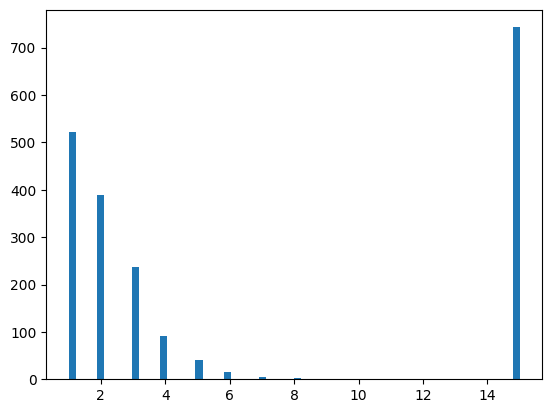

In [6]:
plt.hist(mkbatch(2048)[1].to(torch.float32).cpu(), bins=64)

(array([1516.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  420.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   94.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,   16.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           2.]),
 array([1.    , 1.0625, 1.125 , 1.1875, 1.25  , 1.3125, 1.375 , 1.4375,
        1.5   , 1.5625, 1.625 , 1.6875, 1.75  , 1.8125, 1.875 , 1.9375,
        2.    , 2.0625, 2.125 , 2.1875, 2.25  , 2.3125, 2.375 , 2.4375,
        2.5   , 2.5625, 2.625 , 2.6875, 2.75  , 2.8125, 2.875 , 2.9375,
        3.    , 3.0625, 3.125 , 3.1875, 3.25  , 3.3125, 3.375 , 3.4375,
        3.5   , 3.5625, 3.625 , 3.6875, 3.75  , 3.8125, 3.875 , 3.9375,
        4.    , 4.0625, 4.125 , 4.1875, 4.25  , 4.3125

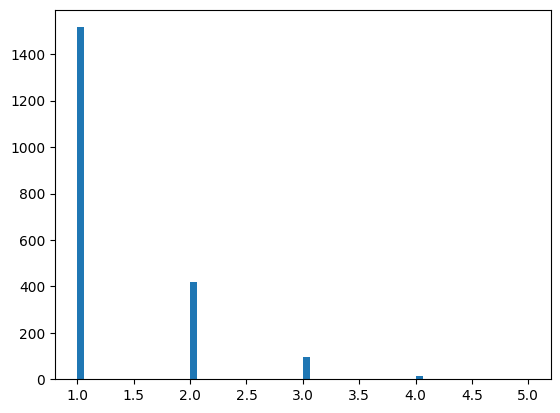

In [7]:
plt.hist(mktunebatch(2048)[1].to(torch.float32).cpu(), bins=64)

# Step 2: Define Transformer Model

In [5]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.embedding = nn.Embedding(input_dim, model_dim // 2, dtype=torch.bfloat16)
        # # seq_len is odd
        # self.fancy_encoding = torch.repeat_interleave(torch.rand((1, seq_len // 2 + 1, model_dim // 2), device=device, dtype=torch.bfloat16), 2, dim=1)
        # # cut off last element since the target vertex is not repeated
        # self.fancy_encoding = self.fancy_encoding[:, :seq_len, :]
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True, dtype=torch.bfloat16)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim, dtype=torch.bfloat16)

    def forward(self, src, key_padding_mask):
        batch_sz = src.size(0)
        src = torch.cat((src, torch.full((batch_sz, 1), MAX_VTXS + 1, device=device)), dim=1)
        embed = torch.cat((self.embedding(src[:,::2]), self.embedding(src[:,1::2])), dim=2)
        output = self.transformer_encoder(embed, src_key_padding_mask=key_padding_mask[:, ::2])
        return self.fc_out(output[:, -1, :])

# Step 3: Make Model

In [6]:
# PARAMS
VOCAB_SIZE = 1 + MAX_VTXS + 1 # pad plus max number of vertices plus target token
MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 1000
BSZ = 2**17 # Batch size
BPE = 8 # Batches per epoch
NHEADS = 2
NLAYERS = 4
DROPOUT = 0 # 0.2
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT).to(device)
model = torch.compile(model)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training data: {NEPOCHS*BPE*BSZ//10**6}M")
print(f"Trainable parameters in the model: {trainable_params//1000}K")

train_err = []
epoch = 0

# clear loss file
open('loss', 'w').close()

Training data: 1048M
Trainable parameters in the model: 200K


MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 1000
BSZ = 2**17 # Batch size
BPE = 8 # Batches per epoch
NHEADS = 2
NLAYERS = 4
DROPOUT = 0 # 0.2

LR of 8e-4 for 1000 epochs to get down to 0.35546875

In [8]:
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT).to(device)
model = torch.compile(model)
model.load_state_dict(torch.load('model.pth', weights_only=True))

LR = 8e-4
WD = 0 # 1e-5

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, cooldown=100)

# Step 4: Train the Model for the first task

In [12]:
def evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mkbatch(BSZ))
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

# figure out if it's doing better on short paths
def evaluate_short():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mkbatch(BSZ))
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output[batch_labels == 1].squeeze(1), batch_labels[batch_labels==1])
    return loss.item()

In [ ]:
while epoch < NEPOCHS:
    model.train()
    with open(f"data/{epoch}.pickle", "rb") as f:
        pickled_stuff = pickle.load(f)
    data = pickled_stuff["data"].to(device)
    label = pickled_stuff["labels"].to(device)
    padding = pickled_stuff["padding"].to(device)
    dataset = TensorDataset(data, label, padding)
    loader = DataLoader(dataset, batch_size=BSZ)
    for batch_src, batch_labels, batch_padding_mask in loader:
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        train_loss = loss.item()
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
    
        # test_loss = evaluate()
        # test_short_loss = evaluate_short()
        
        # test_err.append(test_loss)
        train_err.append(train_loss)
        with open('loss', 'a') as f:
            f.write(f"{train_loss}\n")
        print(f"Epoch {epoch}/{NEPOCHS} \t Train Err: {train_loss:.4f}")

    epoch += 1
    if epoch % 100 == 0:
        torch.save(model.state_dict(), f"model_weights_{epoch}.pth")

/home/sipb/.venv/lib64/python3.12/site-packages/torch/nn/functional.py:6278: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:269.)
  attn_output = scaled_dot_product_attention(
/home/sipb/.venv/lib64/python3.12/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
/tmp/torchinductor_sipb/nj/cnjfg6sudczhbwjig6u6ixumyik7x7ugjn4x43lbushjy4vv4pwz.py:883: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  extern_kernels.mm(reinterpret_tensor(buf1, (1048576, 64), (64, 1), 0), reinterpret_tensor(primals_5, (64, 192),

Epoch 0/1000 	 Train Err: 85.0000
Epoch 0/1000 	 Train Err: 72.0000
Epoch 0/1000 	 Train Err: 63.5000
Epoch 0/1000 	 Train Err: 58.0000
Epoch 0/1000 	 Train Err: 53.7500
Epoch 0/1000 	 Train Err: 51.0000
Epoch 0/1000 	 Train Err: 49.2500
Epoch 0/1000 	 Train Err: 48.0000
Epoch 0/1000 	 Train Err: 47.2500
Epoch 0/1000 	 Train Err: 46.2500
Epoch 0/1000 	 Train Err: 45.5000
Epoch 0/1000 	 Train Err: 45.2500
Epoch 0/1000 	 Train Err: 44.5000
Epoch 0/1000 	 Train Err: 44.2500
Epoch 0/1000 	 Train Err: 44.2500
Epoch 0/1000 	 Train Err: 44.2500
Epoch 1/1000 	 Train Err: 43.5000
Epoch 1/1000 	 Train Err: 43.5000
Epoch 1/1000 	 Train Err: 43.5000
Epoch 1/1000 	 Train Err: 43.5000
Epoch 1/1000 	 Train Err: 43.2500
Epoch 1/1000 	 Train Err: 43.2500
Epoch 1/1000 	 Train Err: 43.0000
Epoch 1/1000 	 Train Err: 43.0000
Epoch 1/1000 	 Train Err: 42.7500
Epoch 1/1000 	 Train Err: 42.5000
Epoch 1/1000 	 Train Err: 42.5000
Epoch 1/1000 	 Train Err: 42.7500
Epoch 1/1000 	 Train Err: 42.7500
Epoch 1/1000 	

In [125]:
# """
# Now let's figure out what it's doing. 

# step 1: figure out what people are attending to 
# """

# example_graph, answer, padding = mkbatch(1)
# sentance_embeddings = model.full_embedding(example_graph)[0,:,:][example_graph.flatten() != 0]
# WQ,WK,WV = torch.split(model.transformer_encoder.layers[0].self_attn.in_proj_weight, (MODEL_DIM, MODEL_DIM, MODEL_DIM))

# Q = sentance_embeddings@WQ
# K = sentance_embeddings@WK

# raw_scores = Q @ K.T / sqrt(MODEL_DIM)
# soft = torch.softmax(raw_scores, dim=-1).detach().cpu().to(float).numpy()
# plt.imshow(soft)
# plt.show()

# print(example_graph)

# print(Q)

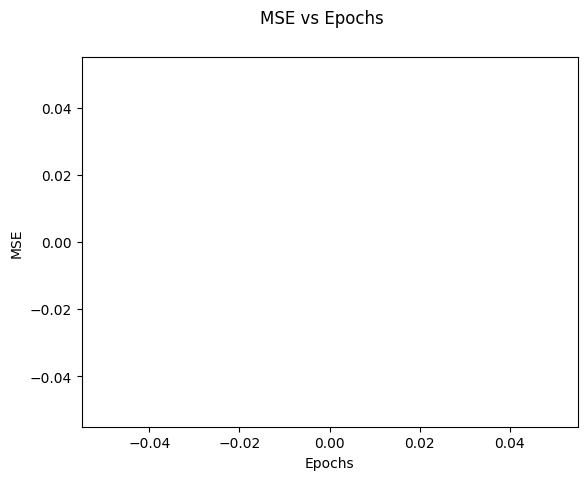

In [21]:
plt.suptitle('MSE vs Epochs')
plt.plot(train_err, label='Train', color='blue')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

(array([[3.1870e+04, 4.5000e+01, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.3300e+02, 2.9200e+02,
         4.8201e+04]]),
 array([ 1.   ,  1.28 ,  1.561,  1.84 ,  2.121,  2.4  ,  2.68 ,  2.96 ,
         3.24 ,  3.52 ,  3.8  ,  4.08 ,  4.36 ,  4.64 ,  4.92 ,  5.2  ,
         5.48 ,  5.76 ,  6.04 ,  6.32 ,  6.6  ,  6.88 ,  7.16 ,  7.44 ,
         7.72 ,  8.   ,  8.28 ,  8.56 ,  8.84 ,  9.12 ,  9.4  ,  9.68 ,
         9.96 , 10.24 , 10.52 , 10.805, 11.08 , 11.36 , 11.64 , 11.92 ,
        12.2  , 12.484, 12.76 , 13.04 , 13.32 , 1

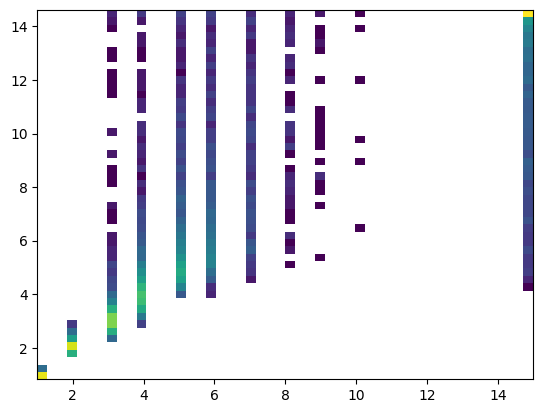

In [13]:
batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mkbatch(BSZ))
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
batch_src[0], batch_labels[0], output[0]
x = batch_labels.detach().to(torch.float16).cpu().numpy().flatten()
y = output.detach().to(torch.float16).cpu().numpy().flatten()
plt.hist2d(x, y, bins=50, norm=mpl.colors.LogNorm())

In [14]:
evaluate()

0.353515625

# Step 5: Fine Tune

In [19]:
N_TUNE_EPOCHS = 100
TUNE_LR = 1e-5
TUNE_WD = 0 # 1e-5

tune_criterion = nn.MSELoss()
tune_optimizer = torch.optim.Adam(model.parameters(), lr=TUNE_LR, weight_decay=TUNE_WD)

tune_train_err = []

# clear loss file
open('tune_loss', 'w').close()

In [20]:
def tune_evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = mktunebatch(BSZ)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

In [23]:
for epoch in range(N_TUNE_EPOCHS):
    model.train()
    train_loss = 0
    batch_src, batch_labels, batch_padding_mask = mktunebatch(BSZ)
    optimizer.zero_grad()
    output = model(batch_src, batch_padding_mask)
    loss = criterion(output.squeeze(1), batch_labels)
    train_loss = loss.item()
    loss.backward()
    optimizer.step()
    
    tune_train_err.append(train_loss)
    with open('tune_loss', 'a') as f:
        f.write(f"{train_loss}\n")
    print(f"Epoch {epoch}/{N_TUNE_EPOCHS} \t Train Err: {train_loss:.4f}")

    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"tune_model_weights_{epoch + 1}.pth")

Epoch 1/100 	 Train Err: 2.8906
Epoch 2/100 	 Train Err: 0.3340
Epoch 3/100 	 Train Err: 0.1709
Epoch 4/100 	 Train Err: 0.2373
Epoch 5/100 	 Train Err: 0.2520
Epoch 6/100 	 Train Err: 0.1953
Epoch 7/100 	 Train Err: 0.1963
Epoch 8/100 	 Train Err: 0.2236
Epoch 9/100 	 Train Err: 0.2119
Epoch 10/100 	 Train Err: 0.1777
Epoch 11/100 	 Train Err: 0.1660
Epoch 12/100 	 Train Err: 0.1787
Epoch 13/100 	 Train Err: 0.1816
Epoch 14/100 	 Train Err: 0.1562
Epoch 15/100 	 Train Err: 0.1377
Epoch 16/100 	 Train Err: 0.1377
Epoch 17/100 	 Train Err: 0.1387
Epoch 18/100 	 Train Err: 0.1289
Epoch 19/100 	 Train Err: 0.1162
Epoch 20/100 	 Train Err: 0.1079
Epoch 21/100 	 Train Err: 0.1108
Epoch 22/100 	 Train Err: 0.1099
Epoch 23/100 	 Train Err: 0.1021
Epoch 24/100 	 Train Err: 0.0918
Epoch 25/100 	 Train Err: 0.0913
Epoch 26/100 	 Train Err: 0.0913
Epoch 27/100 	 Train Err: 0.0859
Epoch 28/100 	 Train Err: 0.0820
Epoch 29/100 	 Train Err: 0.0767
Epoch 30/100 	 Train Err: 0.0776
Epoch 31/100 	 Trai

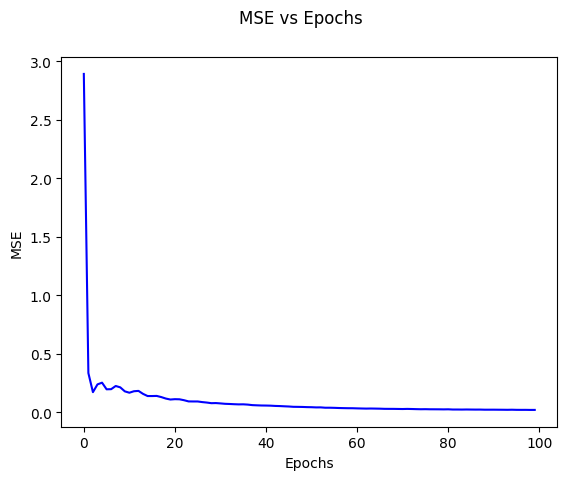

In [24]:
plt.suptitle('MSE vs Epochs')
plt.plot(tune_train_err, label='Train', color='blue')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [26]:
tune_evaluate()

0.0189208984375

(array([[2.6100e+02, 8.9530e+03, 8.2329e+04, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00]]),
 array([1.   , 1.1  , 1.2  , 1.3  , 1.4  , 1.5  , 1.6  , 1.699, 1.8  ,
        1.9  , 2.   , 2.1  , 2.2  , 2.3  , 2.398, 2.5  , 2.6  , 2.7  ,
        2.8  , 2.898, 3.   , 3.1  , 3.2  , 3.299, 3.398, 3.5  , 3.6  ,
        3.7  , 3.799, 3.898, 4.   , 4.1  , 4.2  , 4.297, 4.4  , 4.5  ,
        4.6  , 4.7  , 4.797, 4.9  , 5.   , 5.098, 5.2  , 5.3  , 5.4  ,
        5.5  , 5.598, 5.7  , 5.797, 5.9  , 6.   ], dty

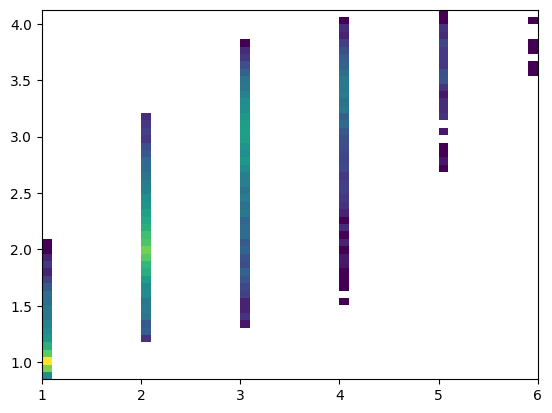

In [25]:
batch_src, batch_labels, batch_padding_mask = mktunebatch(BSZ)
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
x = batch_labels.detach().to(torch.float16).cpu().numpy().flatten()
y = output.detach().to(torch.float16).cpu().numpy().flatten()
plt.hist2d(x, y, bins=50, norm=mpl.colors.LogNorm())

# Step 6: Test generalization

0.1767578125


(array([[ 241.,  824., 9690., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([ 1.   ,  1.18 ,  1.36 ,  1.54 ,  1.721,  1.9  ,  2.08 ,  2.262,
         2.441,  2.621,  2.8  ,  2.98 ,  3.16 ,  3.34 ,  3.521,  3.701,
         3.88 ,  4.062,  4.242,  4.42 ,  4.6  ,  4.78 ,  4.96 ,  5.14 ,
         5.32 ,  5.5  ,  5.68 ,  5.863,  6.043,  6.223,  6.402,  6.582,
         6.76 ,  6.94 ,  7.12 ,  7.3  ,  7.48 ,  7.66 ,  7.844,  8.02 ,
         8.2  ,  8.38 ,  8.56 ,  8.74 ,  8.92 ,  9.1  ,  9.28 ,  9.46 ,
         9.64 ,  9.82 , 10.   ], dtype=float16),
 array([0.7344, 0.818 , 0.9014, 0.9844, 1.068 , 1.151 , 1.234 , 1.318 ,
        1.402 , 1.485 , 1.568 , 1.652 , 1.735 , 1.819 , 1.902 , 1.986 ,
        2.07  , 2.

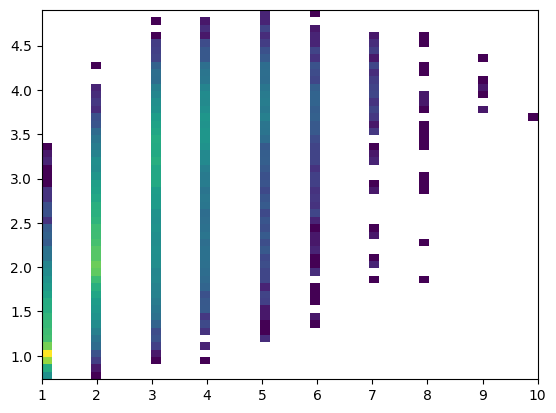

In [28]:
batch_src, batch_labels, batch_padding_mask = mktunebatch(BSZ, test=True)
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
print(criterion(output.squeeze(1), batch_labels).item())
x = batch_labels.detach().to(torch.float16).cpu().numpy().flatten()
y = output.detach().to(torch.float16).cpu().numpy().flatten()
plt.hist2d(x, y, bins=50, norm=mpl.colors.LogNorm())